
<h1><center> Advanced Simulation Methods for Derivatives Pricing </center></h1>
<h3><center> by Anthony Li, </center></h3>
<h3><center> June 2022 </center></h3>

## Introduction

In this project, we will be investigating the use of simulation methods for pricing derivatives under different asset price dynamics, namely Geometric Brownian Motion and Heston's Model. The purpose will be to demonstrate the use of Monte Carlo rather than fitting these models on real data. To calibrate these models to observed asset prices, we will need access to stock option data on exchanges which is costly data. It is easy to calibrate this using Maximum Likelihood Estimation (MLE) or any other preferred method, such as error minimisation.

We will also investigate the use of different variance reduction techniques to improve efficiency and increase rate of convergence. This is important as Monte Carlo simulations can be computationally expensive and these variance reduction techniques can help improve accuracy with less simulations. The techniques we will investigate are antithetic variables, stratified sampling, and control variables.

## 1.1 What is Monte Carlo?
Monte Carlo simulation is a computational technique used to estimate the outcomes of complex systems or processes through random sampling and statistical analysis. It is named after the famous Monte Carlo Casino in Monaco, known for its games of chance and randomness.

In a Monte Carlo simulation, you break down a problem into smaller components or variables and then use random sampling to generate a large number of possible scenarios or outcomes for these variables. By repeatedly simulating these scenarios, you can analyze the distribution of possible outcomes and make probabilistic assessments of the system's behavior.

Monte Carlo simulations are used in a wide range of fields, including finance, engineering, physics, economics, and more. They can be particularly useful when dealing with complex systems that are difficult to model analytically, or when you want to understand the range of possible outcomes and associated probabilities.

One famous example of Monte Carlo simulation is its application in option pricing in finance, specifically the Black-Scholes model, which estimates the value of financial options based on the underlying asset's price, volatility, and time to expiration using random sampling.

For Black-Scholes model, it is a very simple case for vanilla options as we have closed-form solutions to the risk-neutral expectation of the option prices. Therefore, we can simply simulate a series of Normal Distributions (i.e. the brownian motion) and calculate an average, an unbiased approximation of the expectation.

In more complex cases, we will have to simulate the entire brownian motion path with many time steps rather than just the final result. This is usually the case when we do not have closed-form solutions for the risk-neutral expected asset price. For example, this could be derivatives of which value depends on the entire underlying price history rather than the most recent price. A Markov chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

## 1.2 Demonstrating Monte Carlo on Integrals
Before we apply it to derivative pricing, we will demonstrate its effectiveness by comparing a numerical approximation of a complex integral to a simulation based estimation of the same integral.

### Numerical Approximation
To approximate $\bf{I_1 = \int_{0}^{4} \frac{1}{(2+cos(x))^2} dx}$ numerically, I have applied the trapezoidal rule **(Section 1.1.3)**. That is,
\begin{align}
I_1 &= \int_{0}^{4} \frac{1}{(2+cos(x))^2} dx\\
&= \int_{0}^{4} g(x) dx\\
&\approx h\left( \frac{g(0) + g(4)}{2} + \sum_{i=1}^{n-1} g \left(ih \right) \right)\\
&=T(h)
\end{align}
where $\bf{h = \frac{4}{n}} $ and $ \bf{g(x) =  \frac{1}{(2+cos(x))^2}} $.

However, to ensure that the approximation error is guaranteed to be $\leq$ 0.01, I first identified the minimum number of interpolation points such that the total error is bounded by 0.01. I.e. find **n** such that...

\begin{align}
\textrm{Total Error} = T(h) - \int_0^4 g(x) dx = \frac{h^2(4-0)}{12} g''(\xi) \leq 0.01
\end{align}
where

\begin{align}
& g'(x) = \frac{2sin(x)}{(2+cos(x))^3} \\
& g''(x) = \frac{2cos(x)}{(2+cos(x))^3} + \frac{6sin^2(x)}{(2+cos(x))^4} .
\end{align}

**Note**: we can do this because $g \in C^2[0, 4]$, i.e. twice differentiable for the interval $[0,4]$.

To find the upper bound of the Total Error, we must first maximise $g''(x)$ on $(0,4)$. Let $\xi^* \in (0,4)$ take the value which maximises $g''$ on $(0,4)$. This gives us

\begin{align}
\frac{h^2(4-0)}{12} g''(\xi^*) = 0.01 \\
\end{align}

therefore

\begin{align}
n = \sqrt{\frac{1600}{3}g''(\xi^*)} .
\end{align}

In [1]:
# Importing packages I will need
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
# Defining the second derivative of g(x)
def g_2(x):
    y = 2*np.cos(x)/(2+np.cos(x))**3 + 6*np.sin(x)**2/(2+np.cos(x))**4
    return y

# Minimising -g(x) which is same as maximising g(x)
optimizer = opt.minimize(lambda x: -g_2(x),2);
print(optimizer)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.5925925925925184
        x: [ 2.094e+00]
      nit: 4
      jac: [-7.153e-07]
 hess_inv: [[ 2.799e-01]]
     nfev: 12
     njev: 6


In [3]:
# Since we can see above that x falls in the bounds [0,4], we may continue using this maximum of 0.5925...
g2_max = -optimizer['fun']

# Applying the function defined above to find the number of interpolations.
n = np.sqrt(1600/3 * g2_max)
print(n)

17.777777777776667


In [4]:
n = int(np.ceil(n))   # We want the next integer value after n
print(n)

h = 4/n

# Defining the integrand
def g(x):
    y = (2+np.cos(x))**(-2)
    return y

18


In [5]:
# Generating a sequence with increments of size h.
seq = np.linspace(h, 4-h, n-1)

# This is my trapezoidal approximation
I_1 = h*(0.5*(g(0)+g(4))+np.sum(g(seq)))

print('My trapezoidal approximation of the integral is: {:.4f}.'.format(I_1))

My trapezoidal approximation of the integral is: 1.9100.


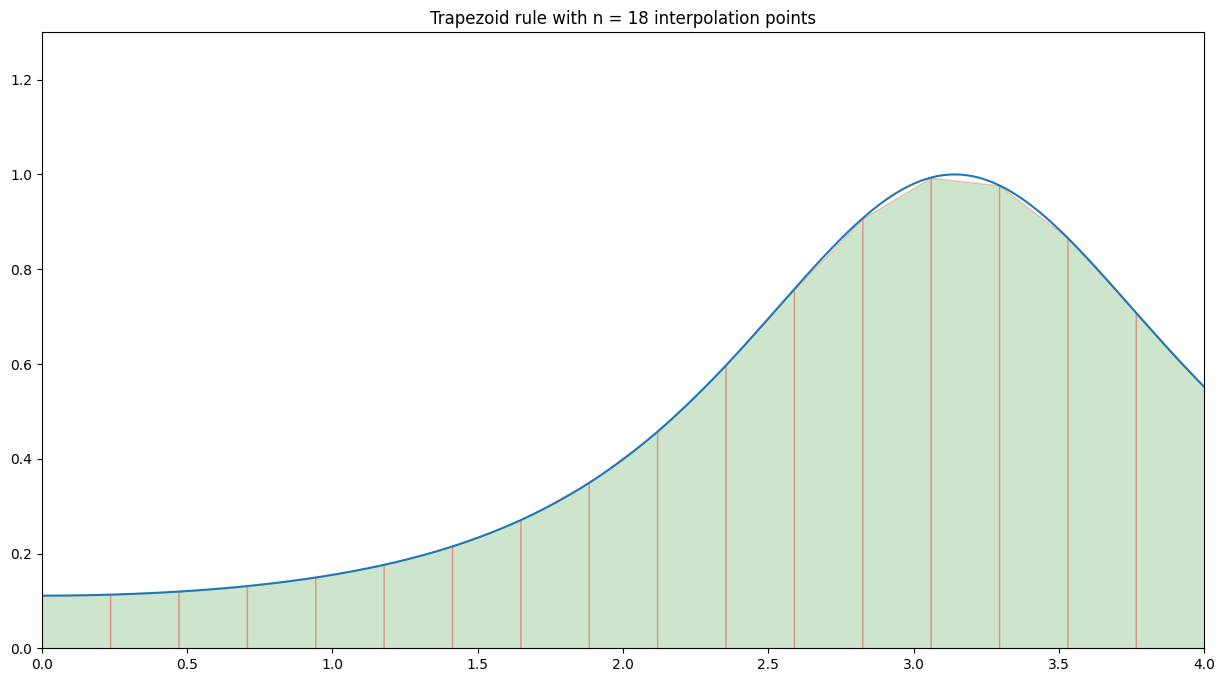

In [6]:
# Creating a sequence of 1000 values of x between 0 and 4 with equal increments.
x =np.linspace(0,4,1000)
y = g(x)

fix, ax = plt.subplots(figsize = (15,8))
ax.plot(x,y)   # Plotting the graph of g
ax.set_xlim([0, 4]); ax.set_ylim([0, 1.3]);   # Setting axis limits

x_trapez = np.linspace(0,4,n)
y_trapez = g(x_trapez)

for i in range(n - 1):
    xs = [x_trapez[i], x_trapez[i+1]]
    ys = [g(x_trapez[i]), g(x_trapez[i+1])]
    ax.fill_between(xs, ys, edgecolor='red', facecolor='g', alpha=0.2)

plt.title('Trapezoid rule with n = {} interpolation points'.format(n));

### Monte Carlo Estimation
To check the accuracy of my numerical approximation, I decided to use a Monte Carlo estimator **(Section 3.2)** to estimate the integral since I cannot find a analytical solution.

\begin{align}
I_1 &= \int_0^4 \frac{1}{(2+cos(x))^2} dx \\
&= 4 \int_0^4 \frac{1}{(2+cos(x))^2} \frac{1}{4} dx \\
&= 4\mathbb{E} \left(\frac{1}{(2+cos(X))^2} \right)
\end{align}

where $X \sim \mathcal{U} (0,4)$.

Therefore, the MC estimator is

\begin{align}
I_1^{MC} &= 4 \frac{1}{n} \sum_{i=1}^n \left(\frac{1}{(2+cos(U_i))^2} \right)
\end{align}

where $U_i \sim \mathcal{U}[0, 4]$ for $i = 1, 2, 3 \ldots$ I also applied the antithetic variable $Y_i = 4 - U_i$ to reduce the variance of my estimation of $I_1$.

**Note:** I will explain in the next part how antithetic variables work in more detail.


In [7]:
rng = np.random.default_rng(seed=56473)
U = rng.random(10**5)*4

Y = (g(U)+g(4-U))/2

I_1_MC = 4*np.mean(Y)

print('My trapezoidal approximation of the integral is: {:.4f}.'.format(I_1))
print('My Monte-Carlo estimation of the integral is   : {:.4f}.'.format(I_1_MC))

My trapezoidal approximation of the integral is: 1.9100.
My Monte-Carlo estimation of the integral is   : 1.9113.


We can see that the Monte-Carlo estimation of the integral is very close to the trapezoidal approximation of the integral. We will now move onto solving integrals with infinite bounds using Monte Carlo.

### Infinite Bounds: Use Substitution

We will try to estimate the value of $I_2$ given by

\begin{align}
I_2 &= \int_{0}^{\infty} x^{\frac{3}{2}}e^{-\frac{x^2}{2}} dx
\end{align}

using the same Monte-Carlo method as above. One important difference is that the integral has infinite bounds therefore we must use a substitution to transform this into an integral with finite bounds. Although we can still approximate an integral with infinite bounds using a distribution with similar bounds, it is much easier and less computationally expensive to simulate uniform distributions.

The first step to estimating $I_2$ using a MC estimator is to transform the integral so that the bounds are finite in order to use the uniform for estimating the integral. The transformation I will be using is $\bf{y=e^{\frac{-x^2}{2}}}$ which gives $\bf{dx = -\frac{1}{x}e^{\frac{x^2}{2}}dy}$, and $\bf{x = \sqrt{-2\ln{y}}}$. Applying this to $I_2$ gives us

\begin{align}
I_2 &= \int_{0}^{\infty} x^{\frac{3}{2}}e^{-\frac{x^2}{2}} dx \\
&= \int_{1}^{0} x^{\frac{3}{2}}e^{-\frac{x^2}{2}} \cdot \left( -\frac{1}{x} e^{\frac{x^2}{2}} \right) dy \\
&= \int_{0}^{1} \sqrt{x} dy \\
&= \int_{0}^{1} (-2 \ln{y})^{\frac{1}{4}} dy \\
&= \mathbb{E} (-2 \ln{Y})^{\frac{1}{4}})
\end{align}

where $Y \sim \mathcal{U}[0,1]$. Therefore my MC estimator of $I_2$ is

\begin{align}
I_2^{MC} = \frac{1}{n} \sum_{i=1}^{n} (-2\ln U_i)^\frac{1}{4}
\end{align}

where $U_i \sim \mathcal{U}[0,1]$ for $i = 1,2,3 \ldots$


**Note**: I could apply other transformations such as $y= \frac{1}{1+x}$ and $y= e^{-x}$.

**Extra**: Although transforming the integral such that the bounds are finite make variance reduction techniques much simpler later on, an alternative could be to apply the transformation $y = x^2$ then sampling from an Exponential distribution to compute the Monte-Carlo estimator.

### Variance Reduction Techniques
The variance reduction methods I will be using are antithetic variables and control variables.

#### Antithetic Variable
Recall that if $U \sim \mathcal{U} (0,1)$ then $1-U \sim \mathcal{U} (0,1)$ also. Therefore it is very computationally cheap to obtain a larger sample of the uniform by taking $1-U$ compared to sampling a further $n$ random variables. Applying this gives us the antithetic pair $(U, 1-U)$ which yields
\begin{align}
\overline{X}_n &=\frac{1}{n} \sum_{i=1}^{n} (-2\ln U_i)^\frac{1}{4} \\
\overline{Y}_n &=\frac{1}{n} \sum_{i=1}^{n} (-2\ln (1-U_i))^\frac{1}{4} \\
\end{align}

giving us the antithetic MC estimator

\begin{align}
I_2^{Antithetic} &=  \frac{\overline{X}_n+ \overline{Y}_n}{2}
\end{align}

Not only does this reduce the variance of the MC estimator because we have a larger sample size, but the covariance of the antithetic pair is also negative which reduces it even further. We can see this by computing the variance of the antithetic MC estimator as follows

\begin{align*}
{\rm Var} (I_2^{Antithetic})
& = {\rm Var} \left( \frac{\overline{X}_n + \overline{Y}_n}{2} \right) \\
& = {\rm Var} \left(\frac1{2n}\sum_{i=1}^n (X_i+Y_i)\right) \\
& = \frac{1}{4n^2} {\rm Var} \left(\sum_{i=1}^n (X_i+Y_i)\right) \\
&= \frac{1}{4n} {\rm Var} \left( X_i+Y_i \right) \\
& = \frac{1}{4n} \left({\rm Var} (X_i) + 2{\rm Cov} (X_i,Y_i) + {\rm Var} (Y_i)
\right) \\
& = \frac{1}{2n} \left({\rm Var} (X) + {\rm Cov} (X,Y) \right).
\end{align*}

Therefore even with half of the original sample size, antithetic variables will have a smaller variance than a standard MC with  the original sample size.

#### Control Variable
There are many different control variates to choose from however the ones I will be using are

\begin{align}
Y_i = U_i-\mathbb{E}(U_i) = U_i - 0.5
\end{align}

and

\begin{align}
Y_i = U_i^2 - \mathbb{E}(U_i^2) = U_i^2 - \frac{1}{3}
\end{align}

where $U_i \sim \mathcal{U} (0,1)$ for $i = 1, 2, 3 \ldots$ The following explanation of how Control Variables work apply to both.

My MC estimator with a control is given by

\begin{align}
I_2^{Control 1} = \overline{X}_n(b) &= \frac{1}{n} \sum_{i=1}^{n} \left( X_i - bY_i  \right)
\end{align}

where $X_i = g(U_i) = (-2 \ln{U_i})^\frac{1}{4} $.

**Simple proof of how control variables work**

Firstly, we have
\begin{align*}
X_i(b) &= g(U_i) - b Y_i \\
\end{align*}
hence
\begin{align*}
\mathbb{E}(X_i(b)) &= \mathbb{E}(g(U_i) - b Y_i) \\
&= \mathbb{E}(g(U_i)) - b  \mathbb{E}(Y_i) \\
&= \mathbb{E}(g(U_i)).
\end{align*}

The variance of the MC estimator after applying a control variable is minimised when we take the value of $b$ as

\begin{align*}
b^* =  \frac{\rm{Cov} (g(U), Y)}{\rm{Var} (Y)}
\end{align*}

which gives us

\begin{align}
{\rm Var} \left( I_2^{control} \right) = \frac{1}{n} \left( {\rm Var}  (g(U)) - \frac{{\rm Cov}
(g(U), Y)^2} {{\rm Var} (Y)} \right).
\end{align}

As you can see above, the control variate reduces the variance most when the covariance between the control variate and the estimator is largest in magnitude.

**Note:** the value of $b^*$ is obtained by minimising the variance with respect to $b$.



## Application and Results

#### Standard MC

In [8]:
nSim = 10**6
# Defining a random number generator with a fixed seed
rng = np.random.default_rng(seed=56473)
U = rng.random(nSim)  # Generating sample of size nSim from standard uniform
Y1 = (-2*np.log(U))**0.25
I_2_MC = np.mean(Y1)
MC_var = np.var(Y1)/nSim
print('My standard Monte-Carlo estimation is         : {:.6g}'.format(I_2_MC))
print('My standard Monte-Carlo estimation variance is: {:.6g}'.format(MC_var))

My standard Monte-Carlo estimation is         : 1.07802
My standard Monte-Carlo estimation variance is: 9.15284e-08


#### Antithetic

In [9]:
Y2 = (-2*np.log(1-U))**0.25
I_2_Antithetic = np.mean((Y1+Y2)/2)
Antithetic_var = np.var((Y1+Y2)/2)/nSim
print('My Antithetic Estimation is         : {:.6g}'.format(I_2_Antithetic))
print('My Antithetic Variance is           : {:.6g}'.format(Antithetic_var))
print('Variance reduction compared to MC is: {:.6g}'.format( (MC_var-Antithetic_var)/MC_var))

My Antithetic Estimation is         : 1.0779
My Antithetic Variance is           : 5.51603e-11
Variance reduction compared to MC is: 0.999397


#### Control 1: $Y_i = U_i-\mathbb{E}(U_i) = U_i - 0.5 $

In [10]:
control = U-0.5
b = np.cov(Y1,control)[0,1]/(1/12)   # The first part gives the covariance matrix hence we must take the value of the off-diagonal
I_2_Control = np.mean(Y1-b*control)
Control_var = np.var(Y1-b*control)/nSim
print('My Control Variable estimation is   : {:.6g}'.format(I_2_Control))
print('My Control Variable variance   is   : {:.6g}'.format(Control_var))
print('Variance reduction compared to MC is: {:.6g}'.format( (MC_var-Control_var)/MC_var))

My Control Variable estimation is   : 1.0778
My Control Variable variance   is   : 3.21894e-09
Variance reduction compared to MC is: 0.964831


#### Control 2: $Y_i = U_i^2 - \mathbb{E}(U_i^2) = U_i^2 - \frac{1}{3}$

In [11]:
control2 = U**2 - 1/3
b2 = np.cov(Y1,control2)[0,1]/np.var(control2)
I_2_Control2 = np.mean(Y1-b2*control2)
Control_var2 = np.var(Y1-b2*control2)/nSim
print('My Control Variable estimation is   : {:.6g}'.format(I_2_Control2))
print('My Control Variable variance   is   : {:.6g}'.format(Control_var2))
print('Variance reduction compared to MC is: {:.6g}'.format( (MC_var-Control_var2)/MC_var))

My Control Variable estimation is   : 1.07785
My Control Variable variance   is   : 7.66845e-09
Variance reduction compared to MC is: 0.916218


#### Stratified Sampling

Stratified sampling is a sampling technique used in statistics and research to improve the representativeness of a sample by dividing the population into subgroups or strata and then selecting samples from each subgroup. This method aims to ensure that each subgroup's characteristics are adequately represented in the final sample, which can lead to more accurate and reliable conclusions.

Stratified sampling offers several benefits over simple random sampling, particularly when dealing with populations that have diverse characteristics. It helps ensure that important subgroups are not underrepresented in the sample, which can lead to more accurate and reliable statistical inferences. However, it can be more complex to implement and requires prior knowledge of the population's characteristics to create meaningful strata.

In [12]:
j = range(1,nSim+1) # Creating a sequence of integers from 1 to nSim+1
Strat_1 = (-2*np.log((U+j-1)/nSim))**0.25
Strat_2 = (-2*np.log((j-U)/nSim))**0.25

sol_Strat = np.mean((Strat_1+Strat_2)/2)
print('My Stratified Sampling estimation is: {:.9g}'.format(sol_Strat))

My Stratified Sampling estimation is: 1.07790026


#### Graph of Estimations using different sample sizes

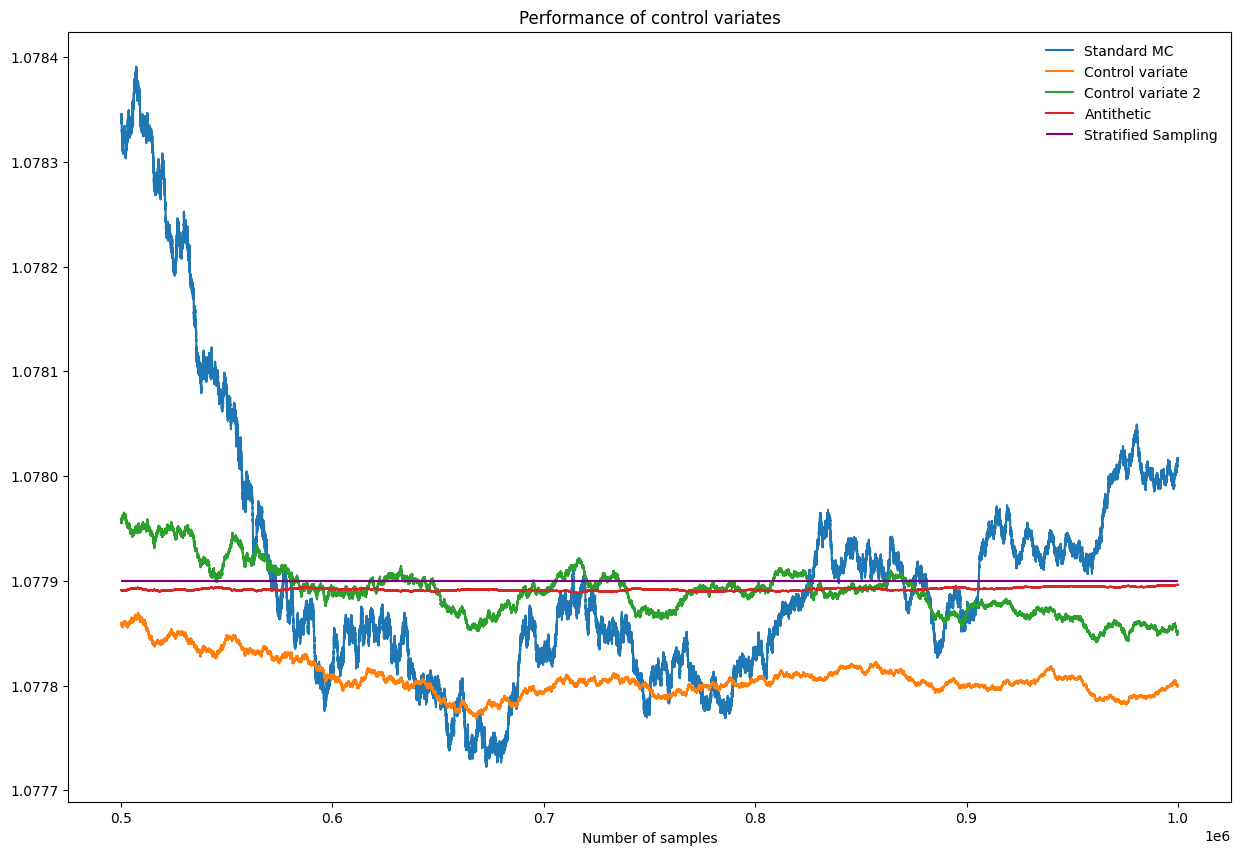

In [13]:
# Instead of starting from a sample size of 1, I am going to start from half of the original sample size
start_plot = nSim // 2

_, ax = plt.subplots(figsize=(15,10))

xx = np.arange(start_plot + 1, nSim + 1)
ax.plot(xx, np.cumsum(Y1)[start_plot:] / xx, label='Standard MC')
ax.plot(xx, np.cumsum(Y1-b*control)[start_plot:] / xx, label='Control variate')
ax.plot(xx, np.cumsum(Y1-b2*control2)[start_plot:] / xx, label='Control variate 2')
ax.plot(xx, np.cumsum((Y1+Y2)/2)[start_plot:] / xx, label='Antithetic')
ax.hlines(sol_Strat, xmin=start_plot, xmax=nSim, color='purple', label='Stratified Sampling')
ax.set_xlabel('Number of samples');
ax.set_title('Performance of control variates');
ax.legend(frameon=False);

|      | Estimation of $I_2$ | Variance of Estimation
| :--- | :---: | :---: |
| **Stratified Sampling**| $1.07790$ | N/A |
| **Monte Carlo**| $1.07802$ | $9.15284e-08$ |
| **Antithetic**| $1.07790$ | $5.51603e-11$|
| **Control 1**| $1.07780$ | $3.21894e-09$ |
| **Control 2**| $1.07785$ | $7.66845e-09$ |

Looking at the graph, you can clearly see that the antithetic estimation provides the best estimation of $I_2$ even for smaller sample sizes. If we take the Stratified Sampling estimation to be the true value, we can see that the antithetic estimation is almost perfect. Compared to the MC, both control variates perform better however control variate 2 seems to give a better estimation based on the graph although its variance is greater than that of control variate 1.

## 1.3 Simulating Sample of an Unknown Distribution

We have been given the function $f:\mathbb{R}\rightarrow\mathbb{R}$,

$$
f(x) = \left \{ \begin{array}{cc}
\frac{\alpha}{\sqrt{1+x}}, & \textrm{ if } x \in (0, 3), \\
0, & \textrm{ if } x \notin (0,3),
\end{array}
\right.
$$

where $\alpha$ is a constant. Our goal is to simulate a sample from this non-standard distribution. This is important in computational mathematics as not all distributions can be easily sampled therefore we must be able to use Inverse Transform Method or Von Neumann's Acceptance-Rejection to do so.

### Von Neumann's Acceptance-Rejection
Von Neumann's acceptance-rejection method, also known as the Von Neumann algorithm, is a technique used to generate random numbers from a probability distribution that might be difficult to sample directly. This method is particularly useful when dealing with distributions that are complex or not easily invertible.

For Von Neumann's Acceptance-Rejection, we aim to find an envelope $g(x)$ that gives us the smallest possible value of $c$ that guarantees the inequality $f(x) \leq cg(x) \quad \forall x \in  (0,3)$. This is because we want to maximise the acceptance rate which is given by $\frac{1}{c}$. However, we must also consider the convenience of generating a sample from $g(x)$. We preferably want $g(x)$ to be a distribution such that there are already built in functions to generate samples from $g$ or a distribution that is easy to apply the inverse transform method on.

I have chosen to use the $\mathcal{U}[0, 3]$ distribution as an envelope to generate a sample from $f$. I.e. take

$$
g(x) = \left \{ \begin{array}{cc}
\frac{1}{3}, & \textrm{ if } x \in (0, 3), \\
0, & \textrm{ if } x \notin (0,3).
\end{array}
\right.
$$

Next, I must minimise the constant $c$ such that it satisfies
\begin{align}
\frac{1}{2\sqrt{1+x}} &\leq c \frac{1}{3-0} \\
\frac{3}{2\sqrt{1+x}} &\leq c.
\end{align}

The LHS is maximised when $x=0$ therefore I take $c^*=\frac{3}{2}$ to be my minimum value. As a result, the acceptance rate is given by $\frac{1}{c^*} = \frac{2}{3}$.

**Von Neumann's acceptance-rejection algorithm**
1. Generate $U \sim \mathcal{U}[0, 1]$
2. Generate $X \sim \mathcal{U}[0, 3]$
3. Accept X if...
\begin{align}
U \leq \frac{f(X)}{cg(X)} = \frac{1}{\sqrt{1+X}}
\end{align}
otherwise reject X.

### Application and Results

The following chunk of code is simple and generates a sample from our desired distribution without using loops and only using vectorised methods making it computationally efficient. The only problem is that the size of the sample is random whereas our goal is to generate 10,000 samples.

In [14]:
# Timing how long it takes to run this algorithm to compare with other methods
from datetime import datetime
start_time = datetime.now()
nSim = 10**5
rng = np.random.default_rng(seed=56473)
U = rng.random(nSim)
X = rng.random(nSim)*3
Y = np.where(U<=1/np.sqrt(1+X), X, 0)   # Sets Y = X if a certain condition is satisfied, otherwise sets Y = 0
Y = Y[Y!=0]   # Removes all zero values
np.mean(Y)
end_time = datetime.now()

print("The acceptance rate is:", len(Y)/10**5)
print("The sample mean is    :", np.mean(Y))
print("The sample size is    :", len(Y))
print('Duration              : {}'.format(end_time-start_time))

The acceptance rate is: 0.66742
The sample mean is    : 1.331331427950982
The sample size is    : 66742
Duration              : 0:00:00.006461


We can use a WHILE loop instead such that the loop is terminated once we reach 10000 samples.

In [15]:
start_time = datetime.now()
nSim = 10**4
sample_AR = []
counter = 0

rng = np.random.default_rng(seed=56473)

for i in range(nSim):
    U = rng.random()
    X = rng.random()*3
    counter += 1
    while (U > 1/np.sqrt(1+X)):
        U = rng.random()
        X = rng.random()*3
        counter += 1
    sample_AR.append(X)

end_time = datetime.now()

acceptance_rate = len(sample_AR)/counter
print('We needed to generate {} candidates in order to obtain {} samples.'.format(counter, nSim))
print('We accepted {:.4g}% of our samples.'.format((nSim/ counter)*100))
print('The mean is: {:.6g}'.format(np.mean(sample_AR)))
print('Duration: {}'.format(end_time-start_time))

We needed to generate 14855 candidates in order to obtain 10000 samples.
We accepted 67.32% of our samples.
The mean is: 1.33154
Duration: 0:00:00.050787


As expected, the WHILE loop takes significantly more time to produce 10000 samples than it takes the first method to produce 66742 samples. This highlights the cost of using loops and hence we should aim to use vectorised methods in computational maths to improve efficiency and speed.

### Plotting Distribution

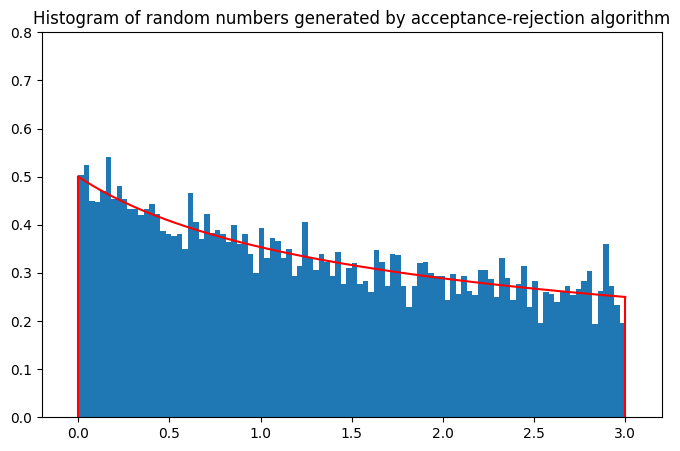

In [18]:
f = lambda x: 1 / (2 * np.sqrt( 1 + x ))
x = np.linspace(0,3, 1000)


_, axs = plt.subplots(figsize=(8, 5))
axs.hist(sample_AR, bins=100, density=True);
axs.set_title('Histogram of random numbers generated by acceptance-rejection algorithm')
axs.set_ylim([0, 0.8]);
axs.set_xlim([-0.2, 3.2]);
axs.plot(x,f(x),color='Red',label='f(x) in (0,3)');
axs.plot([0, 0], [0, f(0)], color = 'red');
axs.plot([3, 3], [0, f(3)], color = 'red')

## Inverse Transform Method
The Inverse Transform Method is a widely used technique for generating random numbers from a given probability distribution. This method is particularly effective when dealing with probability distributions that have known cumulative distribution functions (CDFs) and can be inverted analytically. It's a fundamental approach in random number generation and is often used to transform uniform random numbers into random numbers following a desired distribution.

The Inverse Transform Method ensures that the generated random numbers follow the desired probability distribution. It's a powerful technique because it leverages the properties of CDFs and their inverses to achieve this transformation. The generated random numbers will have the same distribution as the one for which the CDF is known.

This method is especially useful when working with common probability distributions like the exponential, normal (Gaussian), and uniform distributions. However, it's important to note that not all distributions have easily invertible CDFs, and in those cases, alternative methods like the acceptance-rejection method or specialized algorithms might be needed.

Overall, the Inverse Transform Method is a foundational concept in statistical simulations, Monte Carlo methods, and other applications where random numbers from specific distributions are required.

Before applying the inverse transform method, we must first find the CDF of the distribution. For $x \in (0,3)$, we have
\begin{align}
F(x) &= \int_{0}^{x} \frac{1}{2\sqrt{1+v}} dv \\
&= (1+x)^{\frac{1}{2}} -1
\end{align}
hence
$$
F(x) = \left \{ \begin{array}{cc}
0, &\textrm{ if } x \leq 0 \\
(1+x)^{\frac{1}{2}} -1, &\textrm{ if }  0 < x < 3, \\
1, &\textrm{ if } x \geq 3.
\end{array}
\right.
$$

For $x \in (0,3)$, we have $F^{-1}(X) = (X+1)^2 - 1$. Therefore, if $U \sim \mathcal{U}(0, 1)$, then $X = F^{-1}(U) = (U+1)^2 - 1$ is a sample from $f$.

**Algorithm**
1. Generate $U \sim \mathcal{U}(0, 1)$.
2. Set $X = F^{-1}(U) = (U+1)^2 - 1$

### Application and Results

In [21]:
start_time = datetime.now()
nSim = 10**4
rng = np.random.default_rng(seed=56473)
U = rng.random(nSim)
X = (U+1)**2-1
end_time = datetime.now()
print('Duration: {}'.format(end_time-start_time))

Duration: 0:00:00.005062


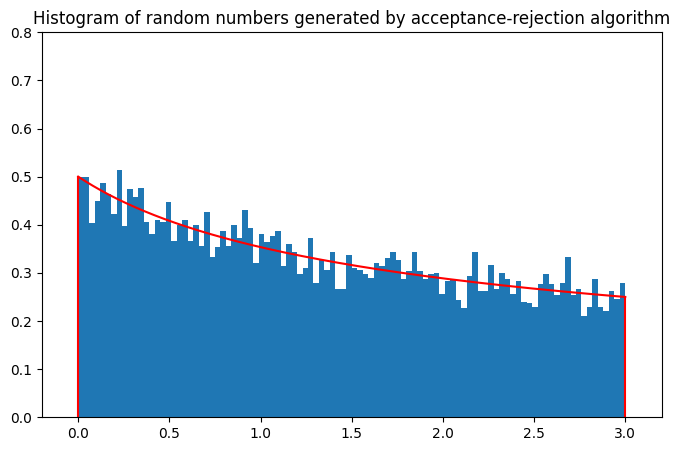

In [24]:
_, axs = plt.subplots(figsize=(8, 5))
axs.hist(X, bins=100, density=True);
axs.set_title('Histogram of random numbers generated by acceptance-rejection algorithm')
axs.set_ylim([0, 0.8]);
axs.set_xlim([-0.2, 3.2]);
axs.plot(x,f(x),color='Red',label='f(x) in (0,3)');
axs.plot([0, 0], [0, f(0)], color = 'red');
axs.plot([3, 3], [0, f(3)], color = 'red')

### Comparison: Von Neumann's A-R VS Inverse Transform Method
The choice between the Inverse Transform Method and the Von Neumann Acceptance-Rejection Method depends on the characteristics of the probability distribution you're working with and the efficiency of each method for generating random numbers from that distribution.

**Inverse Transform Method:**

- **Advantages:** The Inverse Transform Method is highly efficient when the cumulative distribution function (CDF) of the desired distribution is easily invertible analytically. It's straightforward to implement and can generate random numbers that exactly follow the desired distribution.

- **Limitations:** This method might not be applicable when the CDF of the distribution is not easily invertible. Additionally, if the CDF has complex mathematical properties, the calculations involved in the inverse transformation might be computationally expensive.//

**Von Neumann Acceptance-Rejection Method:**

- **Advantages:** The Von Neumann Acceptance-Rejection Method is more versatile and can be used for distributions that might not have easily invertible CDFs. It's applicable to a wider range of scenarios and doesn't require direct knowledge of the target distribution's CDF.

- **Limitations:** This method can be less efficient than the Inverse Transform Method, especially when the enveloping distribution is significantly different from the target distribution. It involves generating additional random numbers (rejections) and might require careful selection of the enveloping distribution for optimal efficiency.

In summary, if the distribution you're working with has a simple and easily invertible CDF, the Inverse Transform Method is often the preferred choice due to its efficiency and directness. However, if the distribution is complex, not analytically invertible, or if you're dealing with a more general scenario where you don't have explicit knowledge of the CDF, the Von Neumann Acceptance-Rejection Method becomes a valuable option.

## 2.1 Derivative Pricing: Straddle

### Closed-Form Solution
First thing to note is that we are working in the Black-Scholes world where the stock price follows a geometric brownian motion. Therefore, we have closed-form solutions for the prices of call and put options.

For a payoff $ H = |S_T - K|$, $H$ a is combination of the payoff of a put and a call with a common strike price, K (this is commonly known as a **straddle** position). I.e.

\begin{align}
 H = |S_T - K| = (S_T-K)^+ + (K - S_T)^+
\end{align}

Therefore the time 0 price, $V_0$, of the european option must equal the total of the price of the put and the call option by no arbitrage. That is,

\begin{align}
V_0 = C_0 + P_0
\end{align}

where $C_0$ and $P_0$ are the prices of the call and put respectively at time 0. Since we are working in the Black-Scholes world, for a risk-neutral measure $\mathbb{Q}$ we have
\begin{align}
V_0 &= \mathbb{E}^\mathbb{Q}(e^{-rT}H) \\
&= \mathbb{E}^\mathbb{Q}(e^{-rT}|S_T-K|) \\
&= \mathbb{E}^\mathbb{Q}(e^{-rT}((S_T-K)^+ + (K - S_T)^+)) \\
&= \mathbb{E}^\mathbb{Q}(e^{-rT}(S_T-K)^+) + \mathbb{E}^\mathbb{Q}(e^{-rT}(K - S_T)^+)) \\
&= C_0 + P_0
\end{align}

which has the general closed-form solutions

\begin{align}
C_0 &= S_0\Phi(d_1) - e^{-rT}K\Phi(d_2)
\end{align}

and by applying the put-call parity we also have

\begin{align}
P_0 &= -S_0\Phi(-d_1) + e^{-rT}K\Phi(-d_2)
\end{align}

where

\begin{align}
d_{1} &= \frac{\log(\frac{S_0}{K}) + (r \pm \frac{\sigma^2}{2})(T)}{\sigma \sqrt{T}} \\
d_2 &= d_1 - \sigma \sqrt{T}
\end{align}

and $\Phi(\cdot)$ is the standard normal CDF.

In [25]:
# Closed-form solution to the price of the Straddle
import scipy.stats as stats
def option_Analytic(S0,K,r,σ,T):
    d1 = (np.log(S0/K)+(r+σ**2/2)*T)/(σ*np.sqrt(T))
    C_0 = S0*stats.norm.cdf(d1) - np.exp(-r*T)*K*stats.norm.cdf(d1-σ*np.sqrt(T))
    P_0 = -S0*stats.norm.cdf(-d1) + np.exp(-r*T)*K*stats.norm.cdf(-d1+σ*np.sqrt(T))
    return C_0+P_0

### Monte-Carlo Estimation

Since the price of the option is given by
\begin{align}
V_0 =  \mathbb{E}^\mathbb{Q}[e^{-rT}|S_T-K|],
\end{align}

the Monte-Carlo estimator for the option price is
\begin{align}
V_0^{MC} =   \frac{1}{n} \sum_{i=1}^{n} e^{-rT}|S_{T,i} - K| \\
\end{align}
where the stock price, at time of maturity T, is given by
\begin{align}
S_{T,i} = S_0 exp\left((r-\frac{\sigma^2}{2})T + \sigma W_{T,i}\right)
\end{align}
where $ W_{T,i} \sim  \mathcal{N} (0,T) $. $W_{T,i}$ are independent realisations of the Wiener process.

The Monte-Carlo estimator relies on the **Strong Law of Large Numbers** which implies that $V_0^{MC}$ is strongly consistent. I.e.

\begin{align*}
\lim _{n \rightarrow \infty} V_0^{MC} = V_0.
\end{align*}



### Mathematical Proof of the Variance of the Monte-Carlo Estimator

\begin{align}
\rm{Var}^\mathbb{Q}(V_0^{MC}) &= \rm{Var}^\mathbb{Q}\left(\frac{1}{n}\sum_{i=1}^{n}e^{-rT}|S_{T,i}-K|\right)\\
&=\left(\frac{1}{n}e^{-rT}\right)^2\rm{var}^\mathbb{Q}\left(\sum_{i=1}^{n}|S_{T,i}-K|\right)\\
&=\frac{1}{n^2}e^{-2rT}\sum_{i=1}^{n}\rm{var}^\mathbb{Q}\left(|S_{T,i}-K|\right) \\
&=\frac{1}{n}e^{-2rT}\rm{var}^\mathbb{Q}\left(|S_{T,1}-K|\right) \\
\end{align}

since

\begin{align}
\rm{Cov}^\mathbb{Q} \left( |S_{T,i}-K|, |S_{T,j}-K| \right) = 0
\end{align}

for $i \neq j$. This is because each realization of the stock price, $S_{T,i}$, are IID.

\begin{align}
\rm{var}^\mathbb{Q}\left(|S_{T,1}-K|\right) &= \mathbb{E}^\mathbb{Q}\left(|S_{T,1}-K|^2\right) - \mathbb{E}^\mathbb{Q}\left(|S_{T,1} - K|\right)^2 \\
    &= \mathbb{E}^\mathbb{Q} \left( S_{T,1}^2 - 2KS_{T,1} + K^2 \right) - \left(e^{rT} \mathbb{E}^\mathbb{Q}\left(e^{-rT}|S_{T,1}-K| \right)\right)^2 \\
    &= \mathbb{E}^\mathbb{Q} \left( S_{T,1}^2 \right) -2Ke^{rT}S_0 + K^2 - \left( e^{rT}V_0 \right)^2
\end{align}

since $\mathbb{E}^\mathbb{Q} (e^{-rT}S_{T,1}) = S_0$.

To find $\mathbb{E}^Q \left(S_{T,1}^2\right)$, we must first establish a few properties of the distribution of $S_{T,1}$. Since  \begin{align}
\log S_{T,1} \sim \mathcal{N} \left(\log S_0 + (r - \frac{1}{2} \sigma^2)T, \sigma^2T\right),
\end{align}
we have
\begin{align}
\log S_{T,1}^2 = 2\log S_{T,1} \sim \mathcal{N} \left(2\log S_0 + 2(r - \frac{1}{2} \sigma^2)T, 4\sigma^2T\right).
\end{align}

**Recall** that the MGF of a normal distribution is $\mathbb{E}({e^{tX}}) = e^{\mu t + \frac{1}{2} \sigma^2 t^2} $ where $X \sim \mathcal{N}(\mu,\sigma^2)$.

Using the MGF of a normal gives us
\begin{align}
\mathbb{E}^\mathbb{Q} \left (S_{T,1}^2 \right) &= \mathbb{E}^\mathbb{Q} \left( e^{\log S_{T,1}^2} \right) \\
&= \mathbb{E}^\mathbb{Q} \left( e^{2\log S_{T,1}} \right) \\
&= exp \left( 2logS_0 + 2(r - \frac{1}{2} \sigma^2)T + \frac{1}{2} 4 \sigma^2T \right) \\
&= S_0^2exp \left( 2rT + \sigma^2T \right).
\end{align}

Collecting all the terms together, we get
\begin{align}
\rm{var}^\mathbb{Q}(V_0^{MC}) &=   \rm{var}^\mathbb{Q}\left( \frac{1}{n}\sum_{i=1}^{n}e^{-rT}|S_{T,i}-K|\right) \\
&= \frac{1}{n}e^{-2rT} \left( S_0^2exp \left( 2rT + \sigma^2T \right)-2Ke^{rT}S_0 + K^2 - \left( e^{rT}V_0 \right)^2 \right)
\end{align}

### Confidence Interval of the Monte-Carlo Estimator
For $\alpha \in (0,1)$ consider the unique number $q_\alpha$ such that

\begin{align}
\Phi (q_\alpha) = 1 - \alpha.
\end{align}

The CLT then yields that $\mu = \mathbb{E}[X]$ belongs to the $1 - 2\alpha$ confidence interval **(Section 3.4)**

\begin{align*}
\left( \overline{X}_n - q_\alpha \frac{\sigma}{\sqrt{n}};\,
\overline{X}_n + q_\alpha \frac{\sigma}{\sqrt{n}} \right)
\end{align*}
as $n \rightarrow \infty$.

Let $\sigma_{MC}^2 = \rm{var}^\mathbb{Q}(V_0^{MC}) $.  Then the $1-2\alpha$ confidence interval for this case is

\begin{align*}
\left( V_0^{MC} - q_\alpha \sigma_{MC};\,
V_0^{MC} + q_\alpha \sigma_{MC} \right).
\end{align*}

For a 95% confidence interval, we have
\begin{align*}
\left( V_0^{MC} - 1.96 \sigma_{MC};\,
V_0^{MC} + 1.96 \sigma_{MC} \right).
\end{align*}

For a 99% confidence interval, we have
\begin{align*}
\left( V_0^{MC} - 2.58 \sigma_{MC};\,
V_0^{MC} + 2.58 \sigma_{MC} \right).
\end{align*}

In [29]:
# Monte Carlo: Estimation, Analytical Variance, Sample Variance, and Confidence Interval
def option_MC(S0, r, σ, T, K, α):
    W = rng.standard_normal(size=nSim)   # Generating sample from standard normal
    S_T = S0 * np.exp((r - σ**2/2) * T + σ * np.sqrt(T) * W)   # Calculating stock price from GBM
    MC_samples = np.exp(-r * T) * abs(S_T - K)

    V_0 = np.mean(MC_samples)

    # Calculating the analytical variance of the estimator
    variance_MC = 1/nSim *np.exp(-2*r*T) * (S0**2*np.exp(2*r*T+σ**2*T) - 2*K*np.exp(r*T)*S0 + K**2 -(np.exp(r*T)*option_Analytic(S0,K,r,σ,T))**2)

    # Calculating confidence interval
    lower = V_0 - stats.norm.ppf(1-α) * np.sqrt(variance_MC)
    upper = V_0 + stats.norm.ppf(1-α) * np.sqrt(variance_MC)

    # Calculating the sample variance of the estimator
    sample_variance_MC = np.var(MC_samples)/nSim

    return V_0, variance_MC, sample_variance_MC, lower, upper

### Application and Results

In [26]:
S0 =4; K=5; r=0.01; σ=0.2; T=1

V_0 = option_Analytic(S0,K,r,σ,T)

print('The analytical price of the european option is: {:.7g}.'.format(V_0))

The analytical price of the european option is: 1.080474.


In [30]:
nSim = 10**6

confidence = 0.95
alpha = (1-confidence)/2

rng = np.random.default_rng(seed=56473)
result = option_MC(S0, r, σ, T, K, alpha)

print('The MC price of the european option is                                  : {:.7g}.'.format(result[0]))
print('The MC variance of the european option is                               : {:.7g}.'.format(result[1]))
print('The MC sample variance of the european option is                        : {:.7g}.'.format(result[2]))
print('The lower bound of the 95% confidence interval of the european option is: {:.7g}.'.format(result[3]))
print('The upper bound of the 95% confidence interval of the european option is: {:.7g}.'.format(result[4]))

The MC price of the european option is                                  : 1.080483.
The MC variance of the european option is                               : 3.885224e-07.
The MC sample variance of the european option is                        : 3.883354e-07.
The lower bound of the 95% confidence interval of the european option is: 1.079262.
The upper bound of the 95% confidence interval of the european option is: 1.081705.


In [ ]:
print('The percentage difference in the analytical and MC price is: {:.4g}.'.format((V_0 - result[0])/V_0 *100))

The percentage difference in the analytical and MC price is: -0.0008833.


## 2.2 Generating Normal Distribution using Box-Muller
For my Monte-Carlo estimator in part i, I need to generate a sample from the normal distribution, $\mathcal{N} (0,T)$. There are multiple methods to doing this such as applying acceptance-rejection using the doubly exponential distribution. I will be using the **Box-Muller** method in my work. The Box-Muller method transforms two independent standard uniformly random variables into two independent standard normally distributed random variables.

**Algorithm:**
1. Generate independent random variables $U_1, U_2 \sim\mathcal{U}(0,1)$;
2. Set $R = -2\log(U_1)$;
3. Set $\theta = 2 \pi U_2$;
4. Set $Z_1 = \sqrt{R} \cos (\theta)$;
5. Set $Z_2 = \sqrt{R} \sin (\theta)$;
6. Set $W_1 = \sqrt{T}Z_1$ and $W_2 = \sqrt{T}Z_2$
7. Return $W_1$ and $W_2$.

We have $W_1, W_2 \sim \mathcal{N} (0,T)$.

The proof of this algorithm involves transforming a double integral using $v = x^2 + y^2$ and $\theta = arctan(\frac{y}{x})$ then setting the integral equal to $1$. I will not go into further detail as the purpose of this project is to implement the relevant advanced simulation techniques. Something I think is worth mentioning is the refinement of the **Box-Muller** using the **Polar Form**. This method avoids evaluating two trigonometric functions, which slows down the algorithm, by generating $\cos(\theta)$ and $\sin (\theta)$ using Cartesian coordinates. Again, I will not go into more detail about how to do this as I just wanted to mention alternative methods.

**Criticisms of the Polar method as an improvement to Box-Muller**:
1. It avoids calculating trigonometric functions at the expense of generating 27% more random variables.
2. The polar method involves a loop. The computational cost of this depends on the programming language.

In [31]:
def option_MC_Box_Muller(S0, r, σ, T, K, α, W):
    S_T = S0 * np.exp((r - σ**2/2) * T + σ * np.sqrt(T) * W)
    MC_samples = np.exp(-r * T) * abs(S_T - K)

    V_0 = np.mean(MC_samples)
    variance_MC = 1/nSim *np.exp(-2*r*T) * (S0**2*np.exp(2*r*T+σ**2*T) - 2*K*np.exp(r*T)*S0 + K**2 -(np.exp(r*T)*option_Analytic(S0,K,r,σ,T))**2)

    lower = V_0 - stats.norm.ppf(1-α) * np.sqrt(variance_MC)
    upper = V_0 + stats.norm.ppf(1-α) * np.sqrt(variance_MC)

    sample_variance_MC = np.var(MC_samples)/nSim

    return V_0, variance_MC, sample_variance_MC, lower, upper

# Generating standard normal using Box-Muller
rng = np.random.default_rng(seed=56473)
U1 = rng.random(500_000)
U2 = rng.random(500_000)
R = -2*np.log(U1)
theta = 2*np.pi*U2
Z1 = np.sqrt(R)*np.cos(theta)
Z2 = np.sqrt(R)*np.sin(theta)
Z = np.concatenate((Z1,Z2))

result_Box_Muller = option_MC_Box_Muller(S0, r, σ, T, K, α, Z)

print('The MC price of the european option is                                  : {:.7g}.'.format(result_Box_Muller[0]))
print('The MC variance of the european option is                               : {:.7g}.'.format(result_Box_Muller[1]))
print('The MC sample variance of the european option is                        : {:.7g}.'.format(result_Box_Muller[2]))
print('The lower bound of the 95% confidence interval of the european option is: {:.7g}.'.format(result_Box_Muller[3]))
print('The upper bound of the 95% confidence interval of the european option is: {:.7g}.'.format(result_Box_Muller[4]))


The MC price of the european option is                                  : 1.080088.
The MC variance of the european option is                               : 3.885224e-07.
The MC sample variance of the european option is                        : 3.889866e-07.
The lower bound of the 95% confidence interval of the european option is: 1.078866.
The upper bound of the 95% confidence interval of the european option is: 1.08131.


## 2.3 Derivatives Pricing: Variance Reduction Techniques

### Antithetic
Since the standard normal distribution is symmetric around 0, if $Z \sim \mathcal{N} (0,1)$ then $-Z \sim \mathcal{N} (0,1)$ also. This gives us the antithetic pair $(Z,-Z)$.

**Note:** I have explained in **1b)** how antithetic variables reduce the variance. The same concept applies here where

\begin{align}
S_{T,i} &= S_0 exp\left((r-\frac{\sigma^2}{2})T + \sigma W_{T,i}\right) \\
S_{T,i}' &= S_0 exp\left((r-\frac{\sigma^2}{2})T - \sigma W_{T,i}\right)
\end{align}

therefore our MC estimator with antithetic variate is given by

\begin{align}
&\overline{X}_n = \frac{1}{n} \sum_{i=1}^{n} e^{-rT}|S_{T,i} - K| \\
&\overline{Y}_n = \frac{1}{n} \sum_{i=1}^{n} e^{-rT}|S_{T,i}' - K| \\
&V_0^{Antithetic} =  \frac{\overline{X}_n+ \overline{Y}_n}{2}.
\end{align}


In [32]:
def option_MC_antithetic(S0, r, σ, T, K):
    rng = np.random.default_rng(seed=56473)
    W = rng.standard_normal(nSim)

    S_T1 = S0 * np.exp((r - σ**2/2) * T + σ * np.sqrt(T) * W)
    S_T2 = S0 * np.exp((r - σ**2/2) * T + σ * np.sqrt(T) * -W)
    MC_samples1 = np.exp(-r * T) * abs(S_T1 - K)
    MC_samples2 = np.exp(-r * T) * abs(S_T2 - K)
    MC_samples = (MC_samples1 + MC_samples2)/2

    return MC_samples.mean(), MC_samples.std() / np.sqrt(nSim)

In [33]:
antithetic = option_MC_antithetic(S0,r,σ,T,K)

print('The antithetic estimation of the price of the option is: {:.7g}.'.format(antithetic[0]))
print('The standard deviation of the antithetic estimation is : {:.7g}.'.format(antithetic[1]))

The antithetic estimation of the price of the option is: 1.080671.
The standard deviation of the antithetic estimation is : 0.0002294192.


### Control Variable

Again, the concept of control variable and how it works is explained in **1b)**. Since we are working in the Black-Scholes world with risk-neutrality, we know that by FTAP we have $\mathbb{E} (e^{-rT}S_T) = S_0$. Therefore a suitable control variable to apply would be

\begin{align}
Y_i = e^{-rT}S_{T,i} - \mathbb{E}^\mathbb{Q} (e^{-rT}S_{T,i}) =  e^{-rT}S_{T,i} - S_0.
\end{align}

This is a valid control since

\begin{align}
\mathbb{E}^\mathbb{Q} (Y_i) &= \mathbb{E}^\mathbb{Q} (e^{-rT}S_{T,i} - \mathbb{E}^\mathbb{Q} (e^{-rT}S_{T,i}) ) \\
&=  S_0 - S_0 \\
&=  0.
\end{align}

Our control estimator of the price of the european option would therefore be

\begin{align}
V_0^{Control 1} = \frac{1}{n} \sum_{i=1}^{n} \left( e^{-rT}|S_{T,i} - K| - b(e^{-rT}S_{T,i} - S_0) \right).
\end{align}

For the optimal value of b, we take
\begin{align}
b^* =\frac{ \rm{Cov}(e^{-rT}|S_{T,i} - K|,e^{-rT}S_{T,i}) }{\rm{Var} (e^{-rT}S_{T,i}) }.
\end{align}


In [34]:
def option_MC_control1(S0, r, σ, T, K):
    rng = np.random.default_rng(seed=56473)
    W = rng.standard_normal(nSim)

    S_T = S0 * np.exp((r - σ**2/2) * T + σ * np.sqrt(T) * W)
    MC_samples = np.exp(-r * T) * abs(S_T - K)

    Y = np.exp(-r*T)*S_T - S0
    b = np.cov(MC_samples, Y)[0,1]/np.var(Y)

    estimator = MC_samples - b*Y

    return estimator.mean(), estimator.std() / np.sqrt(len(estimator))

In [35]:
control1 = option_MC_control1(S0,r,σ,T,K)

print('The control 1 estimation of the price of the option is: {:.7g}.'.format(control1[0]))
print('The standard deviation of the control 1 estimation is : {:.7g}.'.format(control1[1]))

The control 1 estimation of the price of the option is: 1.0807.
The standard deviation of the control 1 estimation is : 0.0003793022.


|      | European option price | Standard Deviation
| :--- | :---: | :---: |
| **Analytical**| $1.080474$ | N/A |
| **Monte Carlo**| $1.080483$ | $0.000623$ |
| **Antithetic**| $1.080671$ | $0.000229$|
| **Control**| $1.080700$ | $0.000379$ |

## 3.1 Euler and Milstein Schemes

Euler and Milstein schemes are numerical methods used for approximating solutions to stochastic differential equations (SDEs), which are equations that involve both deterministic differential terms and stochastic (random) terms. These schemes are particularly important in the field of computational finance, physics, and other areas where random processes are involved.

To demonstrate the use of Euler and Milstein Schemes, we will assume the price of an asset follows the dynamic given by

\begin{align}
dS_t = rS_t dt + \sigma (1+S_t) dW_t
\end{align}

I will be applying 2 different schemes to simulate sample paths for the stock prices that follows the dynamics under the **risk-neutral measure** given by $ dS_t = rS_t dt + \sigma (1+S_t) dW_t^Q $ where $r$ is the risk-free rate and $\sigma >0$. First note that this dynamic can be written as

\begin{align}
S_t = S_0 + \int_0^t r S_t du +  \int_0^t \sigma (1+S_t) dW_u^Q.
\end{align}

### Euler Scheme
The first-order Euler scheme is given by $\hat{S}_0 = S_0$ and

\begin{align}
\hat{S}_{(i+1)h} &= \hat{S}_{ih} + r \hat{S}_{ih} h + \sigma (1+\hat{S}_{ih}) (W_{(i+1)h} - W_{ih}) \\
& =  \hat{S}_{ih} + r \hat{S}_{ih} h + \sigma (1+\hat{S}_{ih}) \sqrt{h} Z_i ,    \qquad i = 0, 1, 2, \ldots.
\end{align}

where $Z_i \sim \mathcal{N}(0,1)$ and $h$ is the step size, that is $ h = \frac{T}{n}$.

However, since $S_t \geq 0$ we need to make a slight adjustment. That is,
\begin{align}
\hat{S}_{(i+1)h} = \max \left( 0, \hat{S}_{ih} + r \hat{S}_{ih} h + \sigma (1+\hat{S}_{ih}) \sqrt{h} Z_i \right).
\end{align}

### Milstein Scheme
An improved version of the Euler Scheme is the Milstein scheme which focuses on improving the diffusion term.

The Milstein scheme  is given by

\begin{align}
\hat{S}_{(i+1)h} &= \max \left(0, \hat{S}_{ih} + r \hat{S}_{ih} h + \sigma (1+\hat{S}_{ih}) (W_{(i+1)h} - W_{ih})  +  
\frac{1}{2} \sigma (1+\hat{S}_{ih}) \sigma \left((W_{(i+1)h} - W_{ih})^2 -h\right) \right) \\
&= \max \left(0, \hat{S}_{ih} + r \hat{S}_{ih} h + \sigma (1+\hat{S}_{ih}) \sqrt{h} Z_i + \frac{1}{2} \sigma^2 (1+\hat{S}_{ih}) h (Z_i^2 - 1) \right)
\qquad  i = 0, 1, 2, \ldots
\end{align}
where $Z_i \sim \mathcal{N}(0,1)$ and $h$ is the step size, that is $ h = \frac{T}{n}$.


Note: we have set a minimum of 0 since the stock price cannot be negative in the real-world.

### Applications and Results

In [36]:
def Euler(z, T, nSteps, r, σ, S0):
    sample = np.zeros(nSteps + 1)  # Pre defining vector of zeros to store values
    sample[0] = S0
    h = T / nSteps

    for i in range(nSteps):
        sample[i + 1] = max(0, sample[i] * (1 + (h * r) + (σ * np.sqrt(h) * z[i])) + (σ * np.sqrt(h) * z[i] ))

    return sample

In [37]:
def Milstein(z, T, nSteps, r, σ, S0):
    sample = np.zeros(nSteps + 1)
    sample[0] = S0
    h = T / nSteps

    for i in range(nSteps):
        sample[i + 1] = max(0, sample[i] * (1 + (h * r) + (σ * np.sqrt(h) * z[i])) + (σ * np.sqrt(h) * z[i] ) + 0.5*σ**2*(sample[i]+1) *h*(z[i]**2-1))

    return sample

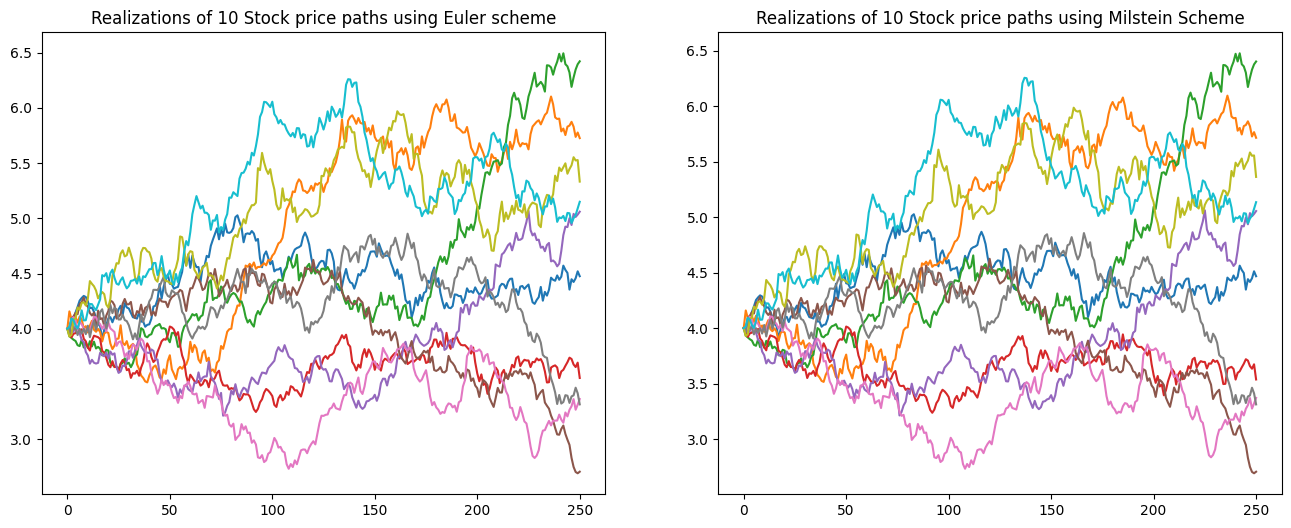

In [38]:
nSims = 10

S0 = 4; r = 0.01; σ = 0.2; T = 1; nSteps = 250

path = np.zeros(n+1)

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

rng = np.random.default_rng(seed=56473)

# Plotting each realisation of the stock price paths
for i in range(nSims):
    z = rng.standard_normal(size=nSteps)
    path = Euler(z, T, nSteps, r, σ, S0)
    ax1.plot(path)
ax1.set_title(f'Realizations of {nSims} Stock price paths using Euler scheme');

rng = np.random.default_rng(seed=56473)
for i in range(nSims):
    z = rng.standard_normal(size=nSteps)
    path = Milstein(z, T, nSteps, r, σ, S0)
    ax2.plot(path)
ax2.set_title(f'Realizations of {nSims} Stock price paths using Milstein Scheme');


## 3.2 Pricing the Derivative under the new Dynamic

Since the new dynamic is still under the **risk-neutral measure**, we still have $V_0 = \mathbb{E}^\mathbb{Q} \left( e^{-rT} |S_T - K| \right)$. Therefore the Monte-Carlo estimator remains the same as the one in section 2.2.

\begin{align*}
    V^{\textrm{MC}}_0(n) = \frac{1}{n} \sum_{i=1}^n e^{-rT} |S_{T,i} - K|,
\end{align*}

where $S_{T,i}$ are independent realizations of the stock price at time of maturity, $T$.

The only thing that is different in this question is the dynamics of the stock price. The price of the stock is now given by

\begin{align}
S_t = S_0 + \int_0^t r S_t du +  \int_0^t \sigma (1+S_t) dW_u.
\end{align}

which has no closed-form solution for the price of call and put options. Therefore we can no longer compute the european option price analytically like we did in 3a). To obtain the stock price at maturity, $T$, we must now apply Euler-type Schemes.

### Euler Scheme

In [39]:
def option_price_Euler(K,α):
    option_payoff = np.zeros(nSim)

    rng = np.random.default_rng(seed=56473)

    for i in range(nSim):
        Z = rng.standard_normal(size=nsteps)
        S = Euler(Z, T, nsteps, r, σ, S0)
        option_payoff[i] = np.exp(-r * T) * abs(S[-1]-K)

    option_price_MC = np.mean(option_payoff)
    MC_std = option_payoff.std() / np.sqrt(nSim)

    lower = option_price_MC - stats.norm.ppf(1-𝛼)*MC_std
    upper = option_price_MC + stats.norm.ppf(1-𝛼)*MC_std

    return option_price_MC, MC_std, lower, upper

In [40]:
nSim = 10**4
nsteps = 250

confidence = 0.95
𝛼 = (1-confidence)/2

S0 = 4; K=5; r=0.01; σ = 0.2; T=1

Euler_Result = option_price_Euler(K,α)

print('The MC estimation of the price of the european option is                : {:.7g}.'.format(Euler_Result[0]))
print('The MC standard deviation of the estimation is                          : {:.7g}.'.format(Euler_Result[1]))
print('The lower bound of the 95% confidence interval of the european option is: {:.7g}.'.format(Euler_Result[2]))
print('The upper bound of the 95% confidence interval of the european option is: {:.7g}.'.format(Euler_Result[3]))

The MC estimation of the price of the european option is                : 1.175995.
The MC standard deviation of the estimation is                          : 0.007334558.
The lower bound of the 95% confidence interval of the european option is: 1.161619.
The upper bound of the 95% confidence interval of the european option is: 1.19037.


### Milstein Scheme

In [41]:
def option_price_Milstein(K,α):
    option_payoff = np.zeros(nSim)

    rng = np.random.default_rng(seed=56473)

    for i in range(nSim):
        Z = rng.standard_normal(size=nsteps)
        S = Milstein(Z, T, nsteps, r, σ, S0)   # we use the exact scheme from above
        option_payoff[i] = np.exp(-r * T) * abs(S[-1]-K)

    option_price_MC = option_payoff.mean()
    MC_std = option_payoff.std() / np.sqrt(nSim)

    lower = option_price_MC - stats.norm.ppf(1-𝛼)*MC_std
    upper = option_price_MC + stats.norm.ppf(1-𝛼)*MC_std

    return option_price_MC, MC_std, lower, upper

In [42]:
Milstein_Result = option_price_Milstein(K,α)

print('The MC estimation of the price of the european option is                : {:.7g}.'.format(Milstein_Result[0]))
print('The MC standard deviation of the estimation is                          : {:.7g}.'.format(Milstein_Result[1]))
print('The lower bound of the 95% confidence interval of the european option is: {:.7g}.'.format(Milstein_Result[2]))
print('The upper bound of the 95% confidence interval of the european option is: {:.7g}.'.format(Milstein_Result[3]))

The MC estimation of the price of the european option is                : 1.176125.
The MC standard deviation of the estimation is                          : 0.007334625.
The lower bound of the 95% confidence interval of the european option is: 1.16175.
The upper bound of the 95% confidence interval of the european option is: 1.190501.
